<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2A_LSTM_BI_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adpating the LSTM model architecture to tackle sparsity

### Install NeuroGym

In [155]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym
Obtaining file:///content/neurogym/neurogym
ERROR: file:///content/neurogym/neurogym does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


### Imports

In [3]:
import neurogym as ngym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Define a Sparse LSTM model

In [4]:
class Sparse_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sparsity_masks):
        super(Sparse_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers)  # Standard LSTM with n layers
        self.sparsity_masks = sparsity_masks  # Binary masks for sparsity

    def forward(self, x): # Applying sparsity on each forward pass
        with torch.no_grad():
            for name, param in self.lstm.named_parameters():
                if 'weight' in name:  # Only applying sparsity mask to weight matrices
                    layer_idx = int(name.split('_l')[1].split('.')[0])  # Extract layer index from name
                    if 'ih' in name:  # Input-to-hidden weights
                        mask = self.sparsity_masks.get(f'weight_ih_l{layer_idx}')
                        param.data *= mask
                    elif 'hh' in name:  # Hidden-to-hidden weights
                        mask = self.sparsity_masks.get(f'weight_hh_l{layer_idx}')
                        param.data *= mask
        output, (hn, cn) = self.lstm(x)
        return output, (hn, cn)

    def apply_sparsity_masks_after_optimiser(self):  # Applying sparsity masks after the optimiser step
        with torch.no_grad():
            for name, param in self.lstm.named_parameters():
                if 'weight' in name:
                    layer_idx = int(name.split('_l')[1].split('.')[0])  # Extract layer index from name
                    if 'ih' in name:  # Input-to-hidden weights
                        mask = self.sparsity_masks.get(f'weight_ih_l{layer_idx}')
                        param.data *= mask
                    elif 'hh' in name:  # Hidden-to-hidden weights
                        mask = self.sparsity_masks.get(f'weight_hh_l{layer_idx}')
                        param.data *= mask


class LSTMNet(nn.Module): # Define the main model with the added linear layer
    def __init__(self, input_size, hidden_size, output_size, num_lstm_layers=2, sparsity_masks=None):
        super(LSTMNet, self).__init__()
        self.lstm = Sparse_LSTM(input_size, hidden_size, num_layers=num_lstm_layers, sparsity_masks=sparsity_masks)  # Sparse LSTM layers
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected layer

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        out = self.fc(lstm_output)
        return out, lstm_output


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creating dataset and adjusting parameters

In [52]:
config = {
    'dt': 200, # Timestep parameter
    'hidden_size': 32, # Hidden size for your LSTM
    'batch_size': 32, # Batch size for training
    'seq_len': 50, # Sequence length for input data
    'envid': 'ReadySetGo-v0', # Task name
    'gain': 2, # Custom gain
    'prod_margin': 10, # Custom production margin
}

env_kwargs = {
    'dt': config['dt'], # Assing timestep parameter
    'gain': config['gain'],  # Controls the measure that the agent has to produce
    'prod_margin': config['prod_margin'], # Controls the interval around the ground truth production time within which the agent receives proportional reward
}
config['env_kwargs'] = env_kwargs

dataset = ngym.Dataset(config['envid'], env_kwargs=config['env_kwargs'], batch_size=config['batch_size'], seq_len=config['seq_len']) # Generate dataset
env = dataset.env

inputs, target = dataset() # Assing inputs and targets
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0] # Find dimensions for data
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = torch.Size([50, 32, 3])
Target has shape (SeqLen, Batch) = (50, 32)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### Generate sparisty matricies

In [6]:
def generate_sparsity_masks(input_size, hidden_size, num_layers, sparsity):
    sparsity_masks = {}  # Dictionary to store masks for each layer
    for layer in range(num_layers): # Loop through each layer in the LSTM (2 times num_layers)
        ih_shape = (4 * hidden_size, input_size if layer == 0 else hidden_size)  # Input to hidden mask shape
        hh_shape = (4 * hidden_size, hidden_size)  # Hidden to hidden mask shape
        sparsity_masks[f'weight_ih_l{layer}'] = (torch.rand(ih_shape) > sparsity).float() # Create and name I-to-H mask
        sparsity_masks[f'weight_hh_l{layer}'] = (torch.rand(hh_shape) > sparsity).float() # Create and name H-to-H mask
    return sparsity_masks

### Training the model

In [156]:
iter_steps = 3000 # Training loops
report_freq = 500 # How often a report on is returned
num_lstm_layers = 2 # Number of LSTM layers
sparsity = 0.5 # Proportion of 0s in binary masks

binary_masks = generate_sparsity_masks(input_size, config['hidden_size'], num_lstm_layers, sparsity)

net = LSTMNet(input_size, config['hidden_size'], output_size, num_lstm_layers, binary_masks) # Create an instance of the sparse LSTM

def train_model(net, dataset, iter_steps, report_freq):

    optimizer = optim.Adam(net.parameters(), lr=0.0003) # AdamW optimiser
    criterion = nn.CrossEntropyLoss() # Loss funciton

    running_loss = 0
    running_acc = 0
    losses = []
    accuracies = []
    start_time = time.time() # Start training timer

    for i in range(iter_steps):  # Loop over training batches
        inputs, labels = dataset()  # Generate a set of data
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        optimizer.zero_grad()  # Reset gradients
        output, hidden = net(inputs)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)  # Calculate loss
        loss.backward()
        optimizer.step()  # Update weights

        net.lstm.apply_sparsity_masks_after_optimiser() # Apply sparsity masks after the optimiser step
        batch_acc = (torch.argmax(output, dim=1) == labels).sum().item() / labels.shape[0]  # Current batch accuracy
        losses.append(loss.item())
        accuracies.append(batch_acc)

        if i % report_freq == report_freq - 1:
            running_loss = sum(losses[-report_freq:]) / report_freq
            running_acc = sum(accuracies[-report_freq:]) / report_freq
            print('Step {}, Loss {:0.4f}, Accuracy {:0.4f}, Time {:0.1f}s'.format(
                i + 1, running_loss, running_acc, time.time() - start_time))
            running_loss = 0 # Reset metrics for next report
            running_acc = 0
    return net, losses, accuracies

net, losses, accuracies = train_model(net, dataset, iter_steps, report_freq) # Call the training function

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step 500, Loss 0.2807, Accuracy 0.9037, Time 7.6s
Step 1000, Loss 0.1646, Accuracy 0.9620, Time 11.8s
Step 1500, Loss 0.1349, Accuracy 0.9619, Time 16.2s
Step 2000, Loss 0.1130, Accuracy 0.9620, Time 20.8s
Step 2500, Loss 0.0878, Accuracy 0.9737, Time 23.2s
Step 3000, Loss 0.0677, Accuracy 0.9880, Time 27.4s


### Sparsity

In [22]:
sparsity = 0
total_params = 0
for param in net.parameters():
    if param.requires_grad:
        total_params += param.numel()
        sparsity += torch.sum(param <= 0.00001).item()

sparsity_ratio = sparsity / total_params
print('Sparsity ratio:', sparsity_ratio)

Sparsity ratio: 0.7497358490566037


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training Metrics

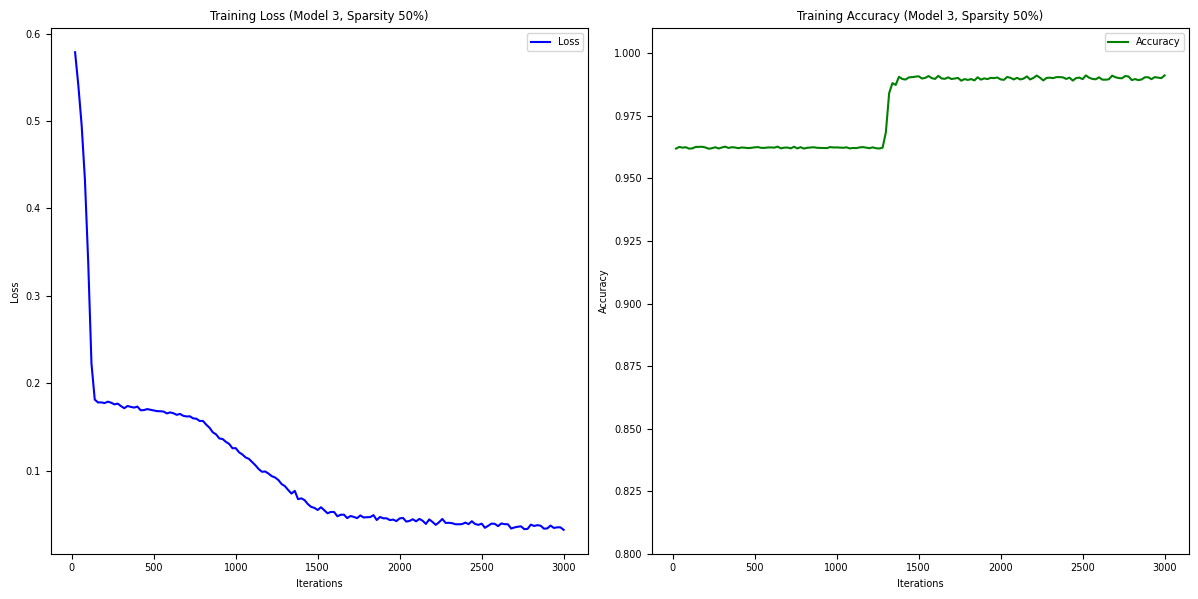

In [7]:
avg_losses = []
avg_accuracies = []
report_freq = 20
for i in range(report_freq - 1, len(losses), report_freq):
    avg_losses.append(sum(losses[i-report_freq+1:i+1]) / report_freq)
    avg_accuracies.append(sum(accuracies[i-report_freq+1:i+1]) / report_freq)

iterations = range(report_freq, len(losses) + 1, report_freq)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(iterations, avg_losses, label='Loss', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss (Model 3, Sparsity 50%)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(iterations, avg_accuracies, label='Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.title('Training Accuracy (Model 3, Sparsity 50%)')
plt.legend()

plt.tight_layout()
plt.show()

### Weight matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


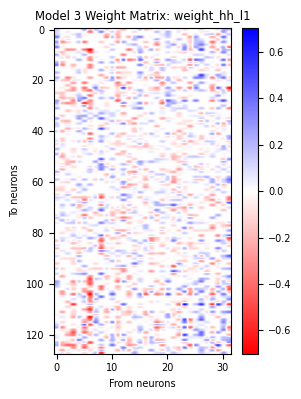

In [157]:

weight_name = 'weight_hh_l1'  # Replace with the desired weight matrix name

W = getattr(net.lstm.lstm, weight_name).detach().numpy()
mask = net.lstm.sparsity_masks.get(weight_name)
if mask is not None:
    mask = mask.numpy()
    W *= mask
wlim = np.max(np.abs(W))

plt.figure(figsize=(3, 4))
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim, aspect='auto')  # 'aspect=auto' ensures good scaling
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title(f'Model 3 Weight Matrix: {weight_name}')

plt.tight_layout()
plt.show()

### Testing

In [158]:
dataset = ngym.Dataset(config['envid'], env_kwargs=config['env_kwargs'], batch_size=1, seq_len=config['seq_len']) # Generate dataset
env = dataset.env # Reset environment

env.reset(no_step=True)
all_activity = []
all_labels = []

for i in range(1000):
    env.new_trial()
    test_inputs, test_labels = dataset()
    test_inputs = torch.from_numpy(test_inputs).type(torch.float)
    test_labels = torch.from_numpy(test_labels.flatten()).type(torch.long)
    test_accs = []
    with torch.no_grad():
        test_output, act = net(test_inputs)
        test_output = test_output.view(-1, output_size)
        criterion = nn.CrossEntropyLoss()
        test_loss = criterion(test_output, test_labels)
        all_activity.append(act.numpy())
        all_labels.append(test_labels.numpy())
        test_acc = (torch.argmax(test_output, dim=1) == test_labels).sum().item() / test_labels.shape[0]
        test_accs.append(test_acc)

print('Test Accuracy:', np.mean(test_accs))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Test Accuracy: 0.98


### PCA

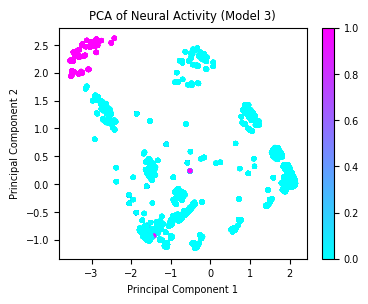

In [164]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

activity = np.vstack(all_activity)
labels = np.concatenate(all_labels)

num_trials, seq_len, num_features = activity.shape
activity = activity.reshape(num_trials, seq_len * num_features)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(activity)

plt.figure(figsize=(4, 3))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='cool' ,s=7)
plt.colorbar()  # Color by test labels
plt.title('PCA of Neural Activity (Model 3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()